# TensorFlow 튜토리얼 #02
# Convolutional Neural Network (컨볼루션 신경망)

원저자 [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ) / 번역 곽병권

## 개요

1장의 튜토리얼에서는 간단한 선형 모델로 MNIST 데이터 세트에서 손으로 쓴 숫자 인식 문제에서 91%의 분류 정확도를 얻을 수 있었습니다.

이 튜토리얼에서는 제안된 연습문제 중 일부를 수행 할 경우 99%이상의 분류 정확도를 얻을 수 있는 간단한 컨볼루션 신경망(Convolutional Neural Network)을 TensorFlow로 구현합니다.

컨볼루션 신경망은 입력 이미지에 대해서 작은 필터를 움직여 작동합니다. 여기서 사용된 필터는 전체 입력 이미지에서 패턴을 인식하는데 반복해서 사용됩니다. 이 방법은 컨볼루션 네트워크를 동일한 수의 변수를 사용하는 완전 연결 네트워크보다 훨씬 강력하게 만듭니다. 작은 필터는 네트워크를 더 빠르게 훈련시킵니다.

기본 선형 대수학, 파이썬 및 Jupyter Notebook 편집기에 익숙해야합니다. 1장을 아직 보지 않았다면, 1장을 보시고 오기를 추천합니다.

## 흐름도

다음 차트는 아래에 구현 된 컨볼루션 신경망의 데이터 흐름을 대략적으로 보여줍니다.

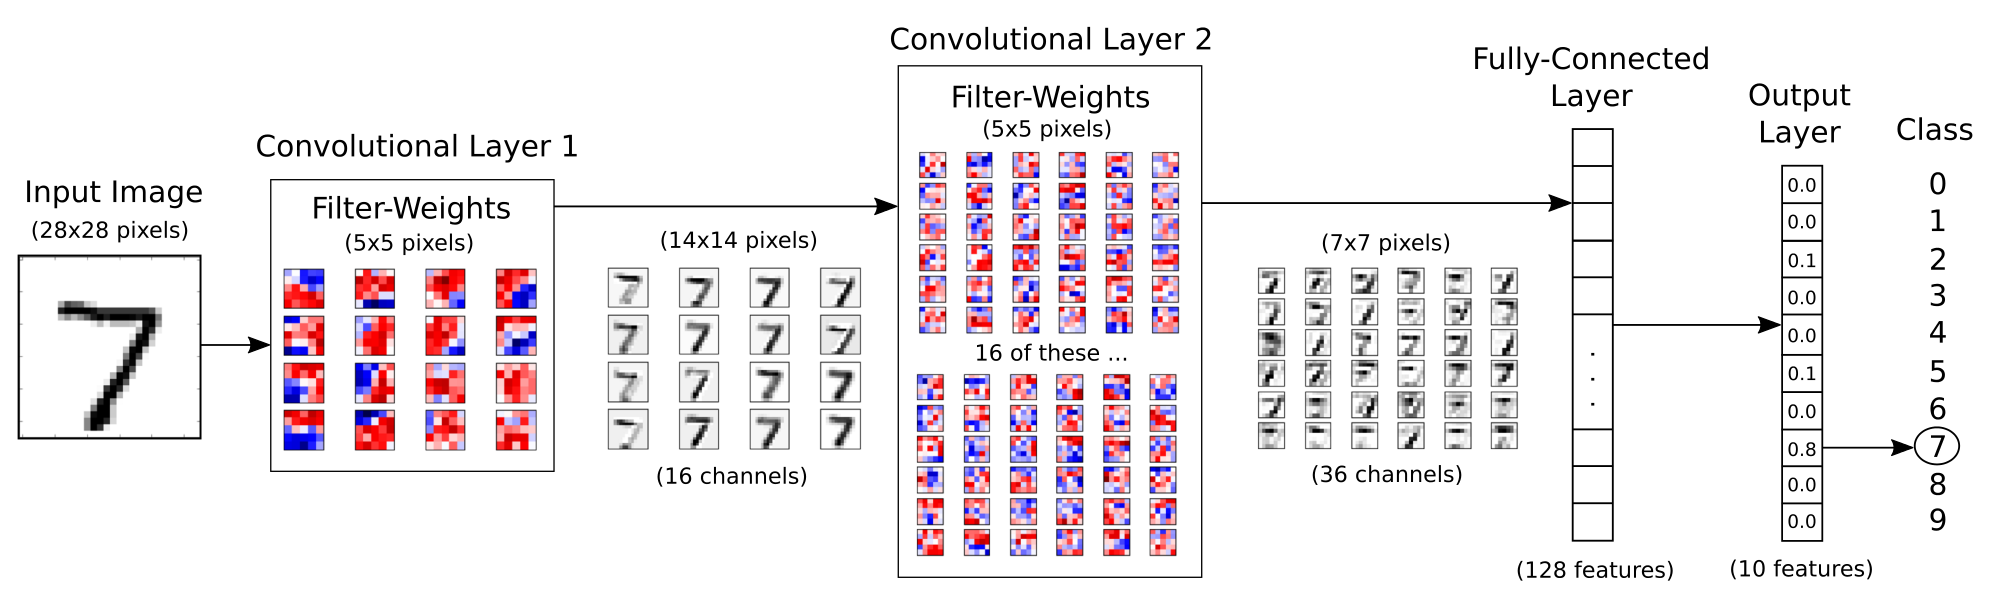

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

입력 이미지는 필터 웨이트를 사용하여 첫 번째 컨볼루션 레이어에서 처리됩니다. 결과적으로 16개의 새로운 이미지가 생성되며, 하나는 컨볼루션 레이어의 각 필터에 해당합니다. 이미지는 또한 다운 샘플링되므로 이미지 해상도가 28x28에서 14x14로 감소합니다.

이 16개의 작은 이미지는 두 번째 컨볼루션 레이어에서 처리됩니다. 이 16개의 채널마다 필터 가중치가 필요하며 이 레이어의 각 출력 채널에 대해 필터 가중치가 필요합니다. 36개의 출력 채널이 있으므로 두 번째 컨볼루션 레이어에는 총 16 x 36 = 576 개의 필터가 있습니다. 결과 이미지는 다시 7x7 픽셀로 다운 샘플링됩니다.

두번째 컨볼루션 레이어의 출력은 각각 7x7 픽셀의 36장의 이미지가 됩니다. 그런 다음 길이가 7 x 7 x 36 = 1764 인 단일 벡터로 평탄화되며, 이는 128개의 뉴런이 있는 완전 연결된 레이어의 입력으로 사용됩니다. 이것은 이미지의 클래스, 즉 어떤 숫자가 이미지에 묘사되어 있는지를 결정하는 데 사용되는 각 클래스에 하나씩, 10개의 뉴런을 가진 완전히 연결된 또 다른 레이어로 공급됩니다.

컨볼루션 필터는 처음에 무작위로 선택되므로 분류가 무작위로 수행됩니다. 입력 이미지의 예측 클래스와 참 클래스 간의 오차는 교차 엔트로피 (cross-entropy)로 측정됩니다. 그런 다음 옵티마이저가 미분의 체인 규칙을 사용하여 컨볼루션 네트워크를 통해, 이 오류를 자동으로 전파하고 분류 오류를 개선하기 위해 필터 가중치를 업데이트합니다. 이것은 분류 오류가 충분히 낮을 때까지 반복적으로 수천 번 반복됩니다.

이 특정 필터 가중치와 중간 이미지는 한 번의 최적화 실행 결과이며, 이 노트북을 다시 실행하면 다르게 보일 수 있습니다.

TensorFlow의 계산은 실제로 단일 이미지 대신 이미지 일괄 처리로 수행되므로 계산이 더 효율적입니다. 즉, TensorFlow에서 구현 될 때 순서도에는 실제로 하나 이상의 데이터 차원이 있습니다.

## 컨볼루션 레이어 (Convolution Layer)

다음 차트는 첫 번째 컨볼루션 레이어에서 이미지를 처리하는 기본적인 아이디어를 보여줍니다. 입력 이미지는 숫자 7을 나타내며 이미지 사본 4개가 여기에 표시되므로 필터가 이미지의 다른 위치로 어떻게 이동되고 있는지 명확하게 볼 수 있습니다. 필터의 각 위치에 대해, 필터와 필터 아래의 이미지 픽셀간에 내적이 계산되므로 출력 이미지에 단일 픽셀이 생성됩니다. 따라서 전체 입력 이미지에서 필터를 이동하면 새로운 이미지가 생성됩니다.

적색 필터 가중치는 필터가 입력 이미지의 검은 픽셀에 대해 긍정적 인 반응을 나타내지 만 파란색 픽셀은 필터가 검은 픽셀에 대해 부정적인 반응을한다는 것을 의미합니다.

아래의 경우 필터는 출력 이미지의 해당 라인에 대한 강한 반응에서 볼 수 있듯이 7그림에서 수평선 부분을 인식합니다.

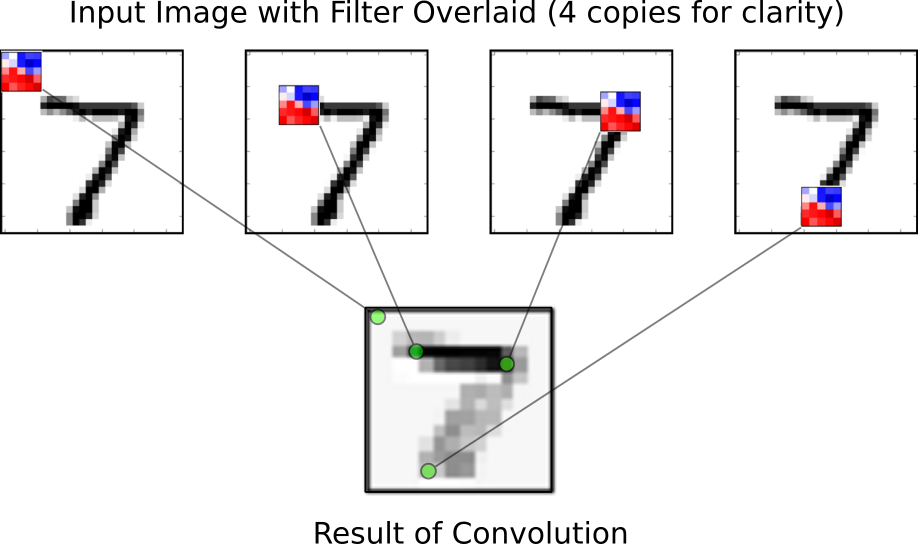

In [2]:
Image('images/02_convolution.png')

입력에서 필터를 이동시키는 단계 크기를 보폭(stride)이라고 합니다. 필터를 수평으로 (x 축) 이동하고 수직으로 이동 (y 축)하는 또 다른 보폭이 있습니다.

아래의 소스 코드에서 스트라이드는 양방향으로 1로 설정됩니다. 즉, 필터는 입력 이미지의 왼쪽 상단에서 시작하여 각 단계에서 오른쪽으로 1 픽셀 이동합니다. 필터가 이미지의 오른쪽 끝에 도달하면 필터가 왼쪽으로 이동하고 이미지 아래로 1 픽셀 이동합니다. 필터가 입력 이미지의 오른쪽 하단 모서리에 도달하여 전체 출력 이미지가 생성 될 때까지이 작업이 계속됩니다.

필터가 입력 이미지의 오른쪽과 하단의 끝에 도달하면 0으로 채워질 수 있습니다 (흰색 픽셀). 이렇게 하면 출력 이미지가 입력 이미지와 정확히 동일한 차원이됩니다.

또한, 컨볼루션의 출력은 음의 값이 0으로 설정되기 때문에 출력이 양수임을 보장하는 소위 정류 선형 유닛 (ReLU)을 통과 할 수 있습니다. 출력은 2x2 픽셀의 작은 창을 고려하고 가장 큰 픽셀 만 유지하는 소위 최대 풀링 (max-pooling)에 의해 다운 샘플링 될 수 도 있습니다. 이것은 입력 이미지의 해상도를 반으로 낮추어 줍니다. 즉, 28x28에서 14x14 픽셀로 다운샘플링이 이루어지게 됩니다.

두 번째 컨볼루션 계층은 16 개의 입력 채널을 필요로하므로 더 복잡합니다. 각 입력 채널에 대해 별도의 필터가 필요하기 때문에 하나의 필터 대신 16개의 필터가 필요합니다. 더불어서, 두 번째 컨볼루션 계층에서 36개의 출력 채널을 원하기 때문에 두 번째 콘볼루션 계층에는 16 x 36 = 576개의 필터가 필요합니다. 각각의 필터가 내부적으로 어떻게 작동하는지 이해하는 것은 매우 어려운 일입니다.

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

이 문서는 Python 3.6.1 (Anaconda) 및 아래의 TensorFlow 버전을 사용하여 개발되었습니다.

In [4]:
tf.__version__

'1.4.0'

## 신경망의 구성

컨볼루션 신경망의 구성은 편의상 여기에 정의되어 있으므로, 아래에서 숫자들을 쉽게 찾고 변경할 수 있으며 노트북을 다시 실행할 수 있습니다.

In [5]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Load Data

MNIST 데이터 세트는 약 12MB이며 주어진 경로에 위치하지 않으면 자동으로 다운로드됩니다.

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터 세트는 현재 로드 되었으며 70.000개의 이미지 및 관련 라벨 (즉, 이미지의 분류)로 구성됩니다. 데이터 집합은 3개의 상호 배타적인 하위 집합으로 나뉩니다. 이 튜토리얼에서는 훈련 및 테스트 세트 만 사용합니다.

In [7]:
print("크기:")
print("- 훈련 세트:\t\t{}".format(len(data.train.labels)))
print("- 테스트 세트:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

크기:
- 훈련 세트:		55000
- 테스트 세트:		10000
- Validation-set:	5000


클래스 레이블은 One-Hot으로 인코딩 됩니다. 즉, 각 레이블은 하나의 요소를 제외하고 모두 0인 요소가 포함 된 10개의 벡터입니다. 이 요소의 색인은 클래스 번호, 즉 연관된 이미지에 표시된 숫자입니다. 테스트 집합에 대한 클래스 수를 정수로 필요로 하므로 바로 계산합니다.

In [8]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

데이터 차원은 아래 소스 코드의 여러 위치에서 사용됩니다. 그것들은 한 번 정의되어 있으므로 아래의 소스 코드에서 숫자 대신 이러한 변수를 사용할 수 있습니다.

In [9]:
# MNIST 데이터는 이미지의 한 변이 28 픽셀입니다.
img_size = 28

# 이미지는 각 변의 크기를 곱한 수의 일차원 배열로 표현이 됩니다.
img_size_flat = img_size * img_size

# 높이와 넓이로 구성된 튜플은 이미지를 재구성하기 위해서 필요합니다.
img_shape = (img_size, img_size)

# 이미지의 컬러 채널의 수: 1 그레이 스케일 이미지의 경우 1
num_channels = 1

# 클래스의 수, 클래스는 0~9까지의 숫자를 의미합니다.
num_classes = 10

### 이미지를 그리는 도움 함수

3x3그리드에 9개의 이미지를 플롯하고 각 이미지 아래에 참 및 예측 클래스를 쓰는 데 사용되는 함수입니다.

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 일부의 이미지를 그려서 데이터가 정확한지 확인해 봅니다.

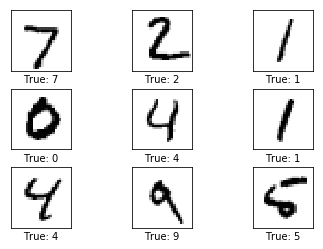

In [11]:
# 테스트 세트의 앞 부부분의 이미지를 가져옵니다.
images = data.test.images[0:9]

# 해당 이미지의 참 분류 값을 가져옵니다.
cls_true = data.test.cls[0:9]

# 위에서 선언한 도움 함수를 이용하여 이미지와 참 값을 그려봅니다.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

TensorFlow의 목적은 동일한 계산이 파이썬에서 직접 수행되는 것보다 훨씬 효율적으로 실행될 수있는 소위 연산 그래프를 구성하는 것입니다. TensorFlow는 실행해야 하는 전체 연산 그래프를 알고 있기 때문에 NumPy보다 더 효율적입니다. NumPy는 한 번에 하나의 수학 연산 만 계산합니다.

또한 TensorFlow는 그래프의 변수를 최적화하여 모델의 성능을 향상시키는 데 필요한 그래디언트를 자동으로 계산할 수 있습니다. 이것은 그래프가 간단한 수학적 표현의 조합이기 때문에 전체 그래프의 그래디언트가 미분에 대한 체인 규칙을 사용하여 계산 될 수 있기 때문입니다.

TensorFlow는 GPU뿐 아니라 멀티 코어 CPU를 활용할 수도 있습니다. Google은 TPU (Tensor Processing Units)라고 불리는 TensorFlow 용 특수 칩을 구축했으며 GPU보다 훨씬 빠릅니다.

TensorFlow 그래프는 아래에 설명 된 다음 부분으로 구성됩니다.

* Placeholder 변수: 변경되는 값을 입력으로 사용할 수 있도록 합니다.
* 모델 변수: 모델이 더 좋은 성능을 내도록 최적화 할 수 있습니다.
* 모델은 본질적으로 Placeholder 변수와 모델 변수의 입력이 제공되면 출력을 계산하는 수학 함수입니다.
* 비용: 변수들을 최적화 하기 위해서 사용되는 측정값 입니다.
* 최적화 기법: 모델의 변수를 변경합니다.

또한 TensorFlow 그래프는 다양한 디버깅 문을 포함 할 수 있습니다. 이 노트북에서는 다루지 않지만 TensorBoard를 사용하여 데이터를 표시하도록 로깅합니다.

### 새 변수 선언을 위한 도움 함수

지정된 형태의 새 TensorFlow 변수를 만들고 임의의 값으로 초기화하는 함수입니다. 이 시점에서 초기화가 실제로 수행되는 것은 아니며 TensorFlow 그래프에서만 정의됩니다.

In [12]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [13]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### 새로운 콘볼루션 레이어를 생성하는 도움 함수

이 함수는 TensorFlow에 대한 계산 그래프에 새로운 콘볼루션 레이어를 만듭니다. 여기서는 실제로 아무 것도 계산되지 않고, TensorFlow 그래프에 수학 공식을 추가하는 것 입니다.

입력은 다음 크기의 4차원 텐서라고 가정합니다.

1. 이미지 번호
2. 각 이미지의 Y 축
3. 각 이미지의 X 축
4. 각 이미지의 채널

입력 채널은 컬러 채널 일 수도 있고 입력이 이전의 콘볼루션 레이어에서 생성 된 경우 필터 채널 일 수도 있습니다.

출력은 다음과 같은 크기의 또 다른 4-Dimension입니다.

1. 이미지 번호, 입력과 동일
2. 각 이미지의 Y 축. 2x2 풀링을 사용하면 입력 이미지의 높이와 너비가 2로 나누어 지게 됩니다.
3. 각 이미지의 X 축. 상동
4. 콘볼루션 필터에 의해 생성 된 채널

In [14]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### 레이어를 펴주는 도움 함수

컨볼루션 계층은 4차원의 출력 텐서를 생성합니다. 우리는 콘볼루션 레이어 다음에 완전히 연결된 레이어를 추가 할 것이므로 완전 연결 레이어의 입력으로 사용 할 수 있도록 4차원 텐서를 2차원으로 줄여야합니다.

In [15]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### 새로운 Fully-Connected Layer를 생성하는 도움 함수

이 함수는 TensorFlow의 계산 그래프에 완전히 연결된 새로운 레이어를 만듭니다. 여기서는 실제로 아무 것도 계산되지 않고, TensorFlow 그래프에 수학 공식을 추가만 합니다.

입력은 모양이 `[dim_images, num_inputs]` 인 2차원 텐서라고 가정합니다. 출력은 모양이 `[dim_images, num_outputs]` 인 2차원 텐서입니다.

In [16]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder 변수

Placeholder 변수는 그래프를 실행할 때마다 변경할 수 있는 TensorFlow 계산 그래프의 입력 값 역할을 합니다.

먼저 입력 이미지의 placeholder 변수를 정의합니다. 이를 통해 TensorFlow 그래프에 입력되는 이미지를 변경할 수 있습니다. 이것은 소위 텐서 (tensor)라고 불리는데, 이는 그것이 다차원 벡터 또는 행렬이라는 것을 의미합니다. 데이터 형은 `float32`로 설정되고 형태는 `[None, img_size_flat]`으로 설정됩니다. 여기서 `None`은 텐서가 임의의 수의 이미지를 보유 할 수 있음을 의미합니다. 각 이미지는 길이가 `img_size_flat`인 벡터입니다.

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

콘볼루션 레이어는 `x`가 4차원 텐서로 인코딩 될 것으로 요구하므로 모양을 바꿔야 합니다. 요구되는 형태는 `[num_images, img_height, img_width, num_channels]`이 됩니다. 첫 번째 차원은 -1을 사용하여 자동으로 추론 할 수 있습니다. 따라서 재구성 작업은 다음과 같습니다.

In [18]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

다음으로 우리는 placeholder `x`에 입력 된 이미지와 관련된 실제 레이블에 대한 placeholder 변수를 갖습니다. 이 placeholder 변수의 모양은`[None, num_classes]`입니다. 이는 임의의 수의 레이블을 가질 수 있음을 의미하며 각 레이블은 이 경우에는 길이가 `num_classes` 인 벡터입니다.

In [19]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

클래스 번호에 대한 placeholder 변수를 사용할 수도 있지만 대신 argmax를 사용하여 이를 계산합니다. 이 값은 TensorFlow 연산자이므로 이 시점에서는 아무 것도 계산되지 않습니다.

In [20]:
y_true_cls = tf.argmax(y_true, axis=1)

### 컨볼루션 레이어 1

첫 번째 컨볼루션 레이어를 만듭니다. `x_image`를 입력으로 취해서 `filter_size1`과 같은 폭과 높이를 가진 `num_filters1`개의 다른 필터를 만듭니다. 마지막으로 2x2 max-pooling을 사용하여 이미지의 절반 크기가 되도록 이미지를 다운 샘플링 합니다.

In [21]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

컨볼루션 층에 의해 출력 될 텐서의 모양을 살펴보십시오. 출력될 형태는 (?, 14, 14, 16)입니다. 즉, 복수의 이미지를 처리할 것이며, 각 이미지는 가로 14 픽셀, 세로 14 픽셀이며 16 개의 다른 채널을 갖게 되고, 16장의 필터가 존재함을 의미합니다.

In [22]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### 컨볼루션 레이어 2

첫 번째 컨볼루션 레이어의 출력을 입력으로 받는 두 번째 컨볼루션 레이어를 만듭니다. 입력 채널들의 수는 제 1컨볼루션 층의 필터들의 수에 대응 합니다.

In [23]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

이 컨볼루션 층에서 출력 될 텐서의 모양을 확인하십시오. 모양은 (?, 7, 7, 36) 입니다. 다시 말하면, 각 이미지의 너비와 높이가 7 픽셀 인 임의의 수의 이미지가 있고, 36개의 채널에 해당하는 필터가 있음을 의미합니다.

In [24]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### 평탄화 레이어 (Flatten Layer)

컨볼루션 계층은 4차원 텐서를 출력합니다. 우리는 이제 완전히 연결된 네트워크에 이를 입력으로 사용하고자 합니다.이 네트워크에서는 텐서가 2차원 텐서로 재구성되거나 평탄화되어야 합니다.

In [25]:
layer_flat, num_features = flatten_layer(layer_conv2)

텐서의 형태가 이제는 (?, 1764)가 되었습니다. 길이 1764의 벡터로 평탄화 된 임의 개의 이미지를 처리한다는 것 입니다. 1764 = 7 x 7 x 36입니다.

In [26]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [27]:
num_features

1764

### 완전 연결 레이어 (Fully-Connected Layer) 1

완전히 연결된 레이어를 네트워크에 추가합니다. 입력은 이전 컨볼루션의 평탄화된 레이어입니다. 완전히 연결된 레이어의 뉴런이나 노드의 수는 `fc_size`입니다. ReLU는 비선형 관계를 배울 수 있도록 사용됩니다.

In [28]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

완전히 연결된 레이어의 출력의 형태는 (?, 128)입니다. 임의의 수의 이미지와 `fc_size` == 128을 의미합니다.

In [29]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### 완전 연결 레이어 (Fully-Connected Layer) 2

입력 이미지가 속하는 클래스 10 개를 결정하기 위해 길이가 10인 벡터를 출력하는 완전히 연결된 레이어를 추가합니다. ReLU는 이 계층에서 사용되지 않습니다.

In [30]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [31]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### 분류 예측

두 번째 완전 연결 계층은 입력 이미지가 10개의 클래스 각각에 속할 확률을 추정합니다. 숫자가 매우 작거나 커지게 되면 해석하기가 어렵기 때문에 각 요소의 값을 0과 1사이의 값으로 제한히고 10개의 요소의 합이 1이 되도록 정규화 합니다. 이것은 softmax 함수를 사용하여 계산되며 결과는 `y_pred`에 저장됩니다.

In [32]:
y_pred = tf.nn.softmax(layer_fc2)

분류 번호는 가장 큰 항목의 색인 입니다.

In [33]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### 비용함수 최적화 하기

입력 이미지를 분류 할 때 모델을 더 잘 만들려면 모든 네트워크 계층의 변수를 어떻게 든 변경해야 합니다. 이를 위해 우리는 모델 `y_pred`의 예측 된 출력을 원하는 출력 `y_true`와 비교하여 모델이 현재 얼마나 잘 수행되는지를 알아야 합니다.

교차 엔트로피는 분류에 사용되는 성능 측정 값입니다. 교차 엔트로피는 항상 양의 연속 함수이며 모델의 예측 된 출력이 원하는 출력과 정확히 일치하면 교차 엔트로피는 0입니다. 따라서 최적화의 목표는 교차 엔트로피를 최소화하여 네트워크 계층의 변수를 변경하여 가능한 한 0에 가깝도록 만드는 것입니다.

TensorFlow에는 교차 엔트로피 계산을 위한 내장 함수가 있습니다. 이 함수는 softmax를 내부적으로 계산하기 때문에 이미 softmax가 적용된 `y_pred`보다는 `layer_fc2`의 출력을 직접 사용해야 합니다.

In [34]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

이제 각각의 이미지 분류에 대한 교차 엔트로피를 계산 했으므로 모델이 각 이미지에 대해 얼마나 잘 작동하는지 측정 할 수 있습니다. 그러나 교차 엔트로피를 사용하여 모델 변수의 최적화를 유도하려면 단일 스칼라 값이 필요하므로 모든 이미지 분류에 대해 교차 엔트로피의 평균을 취합니다.

In [35]:
cost = tf.reduce_mean(cross_entropy)

### 최적화 기법

최소화 해야 하는 비용을 알고 있으므로 최적화 도구를 만들 수 있습니다. 이번에는 경사 하강법의 발전된 형식인 'AdamOptimizer'를 사용하겠습니다.

이 시점에서 최적화는 수행되지 않습니다. 사실, 아무것도 계산되지 않습니다. 나중에 실행을 위해 TensorFlow 그래프에 옵티마이저 개체를 추가하기만 하면 됩니다.

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### 성능 측정

사용자에게 진행 상황을 표시하기 위해 몇 가지 성능 측정 방법이 필요합니다.

예측된 클래스가 각 이미지의 실제 클래스와 같은지 여부는 부울(boolean)의 벡터로 표현할 수 있습니다.

In [37]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

부울 값의 벡터를 부동(float)형으로 형변환하여 False가 0이되고 True가 1이 되도록 한 다음 이 수의 평균을 계산하여 분류 정확도를 계산합니다.

In [38]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow 실행

### TensorFlow session 생성

TensorFlow 그래프가 생성되면 그래프를 실행하는 데 사용되는 TensorFlow 세션을 만들어야 합니다.

In [39]:
session = tf.Session()

### 변수 초기화

`weights`와 `biases`등의 변수는 최적화를 시작하기 전에 초기화 되어야 합니다.

In [40]:
session.run(tf.global_variables_initializer())

### 최적화 반복을 수행하는 도움 함수

트레이닝 세트에는 55,000 개의 이미지가 있습니다. 이 모든 이미지를 사용하여 모델의 그래디언트를 계산하는 것은 시간이 꽤 오래 걸립니다. 따라서 우리는 옵티마이저의 각 반복에서 작은 수의 배치(batch) 이미지만 사용합니다.

메모리가 부족하여 컴퓨터가 다운되거나 충돌이 발생하면, 이 수를 줄이거나 늘릴 수 있지만 배치 크기를 줄이는 경우, 반복 회수를 늘려 주어야 합니다.

In [41]:
train_batch_size = 64

점진적으로 네트워크 계층의 변수를 최적화하기 위해 최적화를 반복을 수행하는 함수입니다. 각 반복은 훈련 세트에서 새로운 데이터 배치를 선택하고 TensorFlow는 이러한 훈련 샘플을 사용하여 최적화 프로그램을 실행합니다. 진행률은 매 100회 한번씩 출력합니다.

In [42]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 분류 오류 이미지의 예를 표시하는 도움 함수

잘못 분류 된 테스트 세트의 이미지 예제를 출력하는 함수

In [43]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 혼란 행렬(Confusion matrix)을 그리기위한 도움 함수

In [44]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 성능을 표시하는 도움 함수

테스트 세트에 대한 분류 정확도를 출력하는 함수입니다.

테스트 세트의 모든 이미지에 대한 분류를 계산하는 데 시간이 걸리기 때문에, 이 함수에서 위의 함수를 직접 호출하여 결과를 다시 사용하므로 각 함수에서 분류를 다시 계산할 필요가 없습니다.

이 함수는 많은 양의 메모리를 사용할 수 있으므로 테스트 세트를 작은 배치로 분할하게 됩니다. 컴퓨터에 메모리가 모자라고 충돌이 발생하면 배치 크기를 줄이고 시도를 해 봐야 합니다.

In [45]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## 최적화 전 성능

모델 변수가 초기화되고 전혀 최적화되지 않았기 때문에 테스트 세트의 정확도는 매우 낮으므로 이미지를 무작위로 분류합니다.

In [46]:
print_test_accuracy()

Accuracy on Test-Set: 12.2% (1215 / 10000)


## 1회 훈련 한 후의 성능

학습률이 아주 작게 설정 되었기 때문에, 한번의 반복으로는 분류 정확도가 향상되지 않습니다.

In [47]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  14.1%
Time usage: 0:00:00


In [48]:
print_test_accuracy()

Accuracy on Test-Set: 13.0% (1299 / 10000)


## 100번 반복 훈련 후의 성능

100번의 훈련 후에는 모델의 분류 정확도가 상당히 향상 되었습니다.

In [49]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:00:03


Accuracy on Test-Set: 64.1% (6408 / 10000)
Example errors:


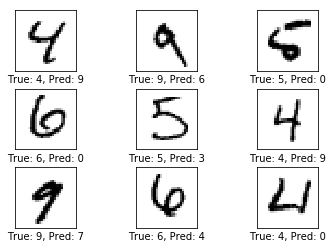

In [50]:
print_test_accuracy(show_example_errors=True)

## 1,000번 훈련 후의 성능

1,000번의 훈련 후에, 모델의 정확도는 크게 향상이 되어 90%이상의 정확도를 보이게 됩니다.

In [51]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  59.4%
Optimization Iteration:    201, Training Accuracy:  81.2%
Optimization Iteration:    301, Training Accuracy:  84.4%
Optimization Iteration:    401, Training Accuracy:  85.9%
Optimization Iteration:    501, Training Accuracy:  89.1%
Optimization Iteration:    601, Training Accuracy:  96.9%
Optimization Iteration:    701, Training Accuracy:  87.5%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  90.6%
Time usage: 0:00:30


Accuracy on Test-Set: 93.6% (9358 / 10000)
Example errors:


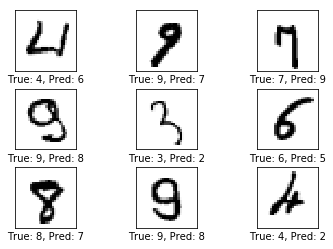

In [52]:
print_test_accuracy(show_example_errors=True)

## 10,000 회의 훈련 후의 성능

10,000번을 반복 훈련 한 후에는 테스트 세트의 데이터에 대해서 99%의 분류 정확도를 보여줍니다.

In [53]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  95.3%
Optimization Iteration:   1101, Training Accuracy:  93.8%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  98.4%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  93.8%
Optimization Iteration:   1701, Training Accuracy:  87.5%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  93.8%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.8% (9875 / 10000)
Example errors:


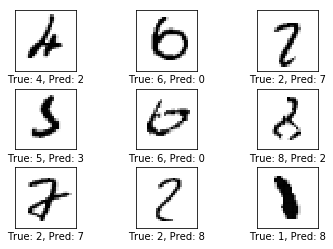

Confusion Matrix:
[[ 974    0    1    0    0    0    1    0    3    1]
 [   0 1127    1    0    0    0    2    2    3    0]
 [   1    2 1013    2    1    0    0    7    5    1]
 [   0    0    1 1003    0    3    0    1    2    0]
 [   0    0    2    0  973    0    1    2    2    2]
 [   1    0    0    7    0  877    1    1    4    1]
 [   6    3    0    1    1    2  942    0    3    0]
 [   0    1    3    2    0    0    0 1018    1    3]
 [   3    0    2    2    1    1    0    2  960    3]
 [   2    3    0    1    6    2    0    6    1  988]]


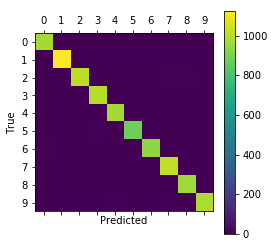

In [54]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## 가중치와 레이어의 시각화

컨볼루션 신경망이 왜 손글씨 숫자를 잘 인식 할 수 있는지 이해하기 위해 컨볼루션 필터와 결과 출력 이미지의 가중치를 시각화해 보겠습니다.

### 컨볼루션 레이어의 가중치를 시각화 하기 위한 도움 함수

In [55]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 컨볼루션 레이어의 출력을 표시하기 위한 도움 함수

In [56]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 입력 이미지

이미지 표시를 위한 도움 함수

In [57]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

아래 예제처럼 사용될 테스트 세트의 이미지를 표시합니다.

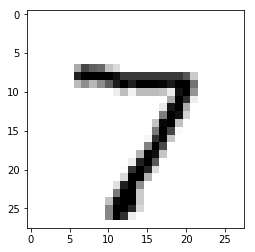

In [58]:
image1 = data.test.images[0]
plot_image(image1)

테스트 세트의 다른 이미지를 표시합니다.

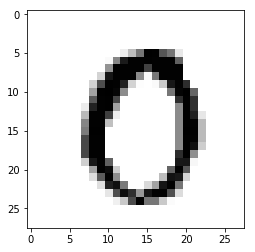

In [59]:
image2 = data.test.images[13]
plot_image(image2)

### 컨볼루션 레이어 1

이제 첫 번째 컨볼루션 레이어에 대한 필터 가중치를 표시합니다.

양의 가중치는 빨간색이고 음수 가중치는 파란색입니다.

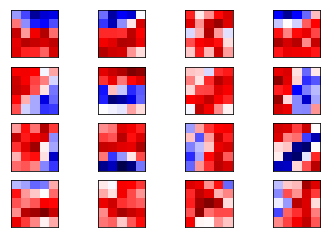

In [60]:
plot_conv_weights(weights=weights_conv1)

이들 컨볼루션 필터 각각을 첫번째 이미지에 적용하면 다음의 출력 이미지가 얻어지며, 그 다음에 두번째 컨볼루션 레이어에 대한 입력으로 사용됩니다. 이러한 이미지는 원본 입력 이미지의 절반인 14 x 14 픽셀로 다운 샘플링됩니다.

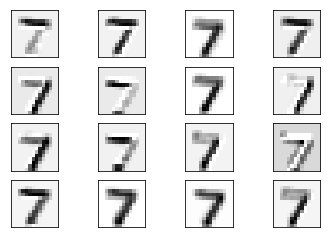

In [61]:
plot_conv_layer(layer=layer_conv1, image=image1)

다음 이미지는 컨볼루션 필터를 두 번째 이미지에 적용한 결과입니다.

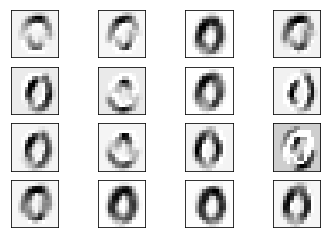

In [62]:
plot_conv_layer(layer=layer_conv1, image=image2)

이러한 이미지에서 컨볼루션 필터의 목적이 무엇인지 알기는 어렵습니다. 다양한 각도에서 바라보거나 혹은 음영효고 처럼 입력 이미지의 여러 변형을 만들었을 뿐 입니다.

### 컨볼루션 레이어 2

이제 두 번째 컨볼루션 레이어에 대한 필터 가중치를 그립니다.

첫 번째 컨볼루션 레이어에는 16 개의 출력 채널이 있으며 이는 두 번째 컨볼루션 레이어에 16 개의 입력 채널이 있음을 의미합니다. 두 번째 컨볼루션 레이어에는 각 입력 채널에 대한 일련의 필터 가중치가 있습니다. 우리는 첫 번째 채널에 대해 필터 웨이츠를 표시해 보겠습니다.

양의 가중치는 빨간색이고 음수 가중치는 파란색입니다.

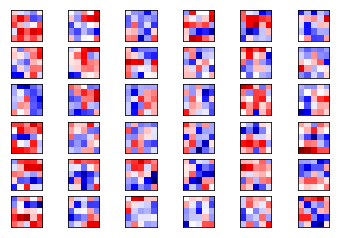

In [63]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

두 번째 컨볼루션 계층에는 16 개의 입력 채널이 있으므로 이와 같은 15 개의 필터 가중치를 추가로 그려볼 수 있습니다. 여기서는 그 중 하나만 더 표시를 해 보겠습니다.

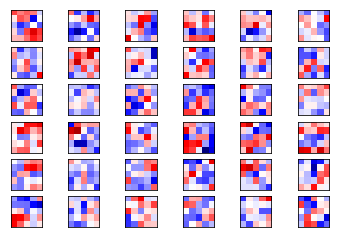

In [64]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

높은 차원 때문에 이러한 필터가 적용되는 방법을 이해하고 추적하는 것은 어려울 수 있습니다.

첫 컨볼루션 레이어에서 출력 된 이미지에 이러한 컨볼루션 필터를 적용하면 다음 이미지가 만들어집니다.

이들 이미지는 첫 번째 컨볼루션 레이어의 이미지 해상도의 절반 인 7 x 7 픽셀로 다시 다운 샘플링됩니다.

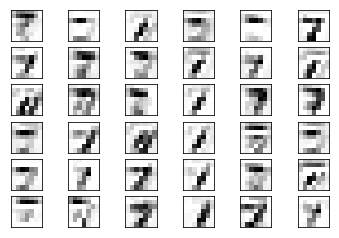

In [65]:
plot_conv_layer(layer=layer_conv2, image=image1)

그리고 두 번째 이미지에 필터 가중치를 적용한 결과입니다.

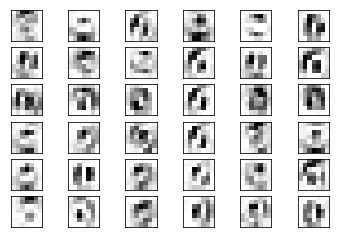

In [66]:
plot_conv_layer(layer=layer_conv2, image=image2)

이러한 이미지에서 두 번째 컨볼루션 레이어가 입력 이미지의 선과 패턴을 감지 할 수 있는 것 처럼 보입니다. 원래 입력 이미지의 지역적 변형에 덜 민감합니다.

그런 다음 이러한 이미지가 병합되어 완전히 연결된 레이어에 입력되지만 여기에는 표시되지 않습니다.

### TensorFlow Session 닫기

이제 TensorFlow를 사용하여 작업을 마쳤으므로 세션을 닫아 리소스를 해제합니다.

In [67]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## 결론

컨볼루션 신경망(Convolutional Neural Network)은 튜토리얼 #01의 단순 선형 모델보다 손으로 쓴 숫자를 인식하는데 훨씬 효과적이라는 것을 알았습니다. 컨볼루션 신경망은 단순 선형 모델이 91% 정확도를 보인것에 비해서 훨씬 높은 99%이상의 분류 정확도를 보여줍니다.

그러나 컨볼루션 신경망(Convolutional Network)의 내부 구현은 훨씬 더 복잡하며 필터 가중치 (filter-weights)가 왜 작동하는지, 때로는 실패하는 이유가 무엇인지는 분명하지 않습니다.

컨볼루션 신경망을 프로그래밍하는 더 쉬운 방법이 제공되면 좋을 것 같습니다. 또한 내부 동작을 시각화하는 더 좋은 방법을 있으면 좋을 것 같습니다.

## 연습문제

아래의 문제들은 TensorFlow 활용 기술을 향상 시키는데 도움이 될 수 있는 몇 가지 제안 사항입니다. TensorFlow를 제대로 사용하는 방법을 배우려면 실습 경험을 얻는 것이 중요합니다.

변경하기전에 이 노트북을 백업 해 두는 것을 추천합니다.

* 매개 변수를 변경하지 않고 노트북을 여러번 실행하면 똑같은 결과가 나타납니까? 임의성의 원인은 무엇입니까?
* 10,000개의 최적화 반복을 실행합니다. 결과가 더 좋습니까?
* 최적화 알고리즘의 학습 속도(learning rate)를 변경하십시오.
* 컨볼루션 필터의 수, 필터의 크기, 완전히 연결된 레이어의 뉴런 수 등과 같은 레이어의 구성을 변경하십시오.
* 완전히 연결된 레이어 뒤에 소위 드롭 아웃 레이어를 추가합니다. 분류 정확도를 계산할 때 드롭 아웃 확률은 0이어야하므로, 이 확률에 대한 placeholder 변수가 필요합니다.
* 컨볼루션 레이어의 ReLU 및 최대 풀링 순서를 변경하십시오. 같은 결과가 나오나요? 가장 빠른 계산 방법은 무엇입니까? 얼마나 많은 계산이 절약되었나요? Sigmoid-functions과 average-pooling에서도 작동합니까?
* 하나 이상의 컨볼루션 및 완전 연결 레이어를 추가합니다. 성능 향상에 도움이됩니까?
* 여전히 좋은 결과를 주는 가능한 가장 작은 구성은 무엇입니까?
* 마지막으로 완전히 연결된 레이어에서 ReLU를 사용해보십시오. 성능이 변합니까? 왜 그럴까요?
* 컨볼루션 레이어에서 풀링을 사용하지 마십시오. 분류 정확도와 교육 시간이 변경됩니까?
* max-pooling 대신에 컨볼루션에서 2x2 stride를 사용해보십시오. 그 차이점은 무엇입니까?
* 이 소스 코드를 너무 많이 보지 않고 직접 프로그램을 다시 제작하십시오.
* 프로그램이 어떻게 작동하는지 동료에게 설명하십시오.

## 라이센스 (MIT)

저작권 (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

사용, 복사, 수정, 병합 할 수있는 권한을 포함하되 이에 국한되지 않고 소프트웨어를 취급하기 위해이 소프트웨어 및 관련 문서 파일 (이하 "소프트웨어")의 사본을 얻는 모든 사람에게 사용 권한이 무료로 부여됩니다 다음 조건에 따라 소프트웨어의 사본을 게시, 배포, 재 라이센스 또는 판매 할 수 있고 소프트웨어를 제공받는 사람에게 허용 할 수 있습니다.

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야합니다.

소프트웨어는 상품성, 특정 목적에의 적합성 및 비 침해에 대한 보증을 포함하여 (단, 이에 한하지 않음) 묵시적이든 명시적이든 어떠한 종류의 보증없이 "있는 그대로"제공됩니다. 제작자 또는 저작권 보유자는 소프트웨어 또는 사용과 관련하여 발생했거나 또는 기타 행위로 인해 발생한 청구, 기타 책임에 대해 어떠한 경우에도 책임을지지 않습니다.